# Tutorial - Initial Conditions

While modelling with respy, you often want to do at least one of the following points:

- Individuals should start with nonzero years of experience for some choice.
- The previous (lagged) choice in the first period can only be a subset of all choices in the model.
- An observed characteristic is not evenly distributed in the population.

Taken together they are called the initial conditions of a model. An initial condition is also called a *seed value* and determines the value of a variable in the first period of a dynamic system.

In the following, we describe how to set the initial condition for each of the the three points for a small Robinson Crusoe Economy. A more thorough presentation of a similar model can be found [here](tutorial-robinson-crusoe.ipynb).

In [1]:
%matplotlib inline

import io
import pandas as pd
import respy as rp
import matplotlib.pyplot as plt

## Experiences

In a nutshell, Robinson can choose between fishing and staying in the hammock every period. He can accumulate experience in fishing which makes him more productive. To describe such a simple model, we write the following parameterization and simulate data with ten periods.

In [2]:
params = """
category,name,value
delta,delta,0.95
wage_fishing,exp_fishing,0.05
nonpec_hammock,constant,1
shocks_sdcorr,sd_fishing,1
shocks_sdcorr,sd_hammock,1
shocks_sdcorr,corr_hammock_fishing,0
"""

options = {
    "n_periods": 10,
    "simulation_agents": 1_000,
    "covariates": {"constant": "1"}
}

In [3]:
params = pd.read_csv(io.StringIO(params), index_col=["category", "name"])
params

value
category       name                       
delta          delta                  0.95
wage_fishing   exp_fishing            0.05
nonpec_hammock constant               1.00
shocks_sdcorr  sd_fishing             1.00
               sd_hammock             1.00
               corr_hammock_fishing   0.00

In [4]:
simulate = rp.get_simulate_func(params, options)
df = simulate(params)

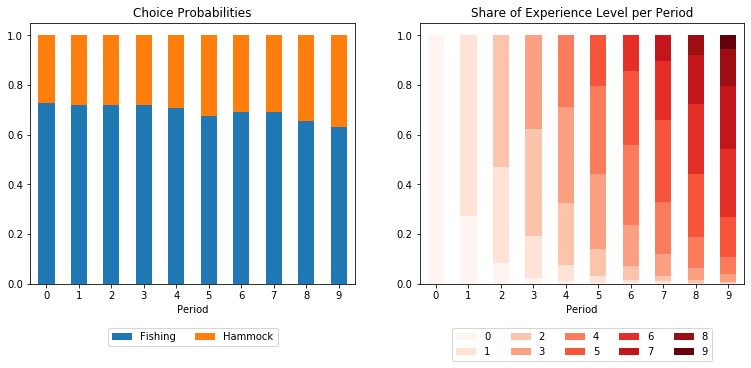

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.8))

(df.groupby("Period").Choice.value_counts(normalize=True).unstack()
 .plot.bar(ax=axs[0], stacked=True, rot=0, title="Choice Probabilities"))
(df.groupby("Period").Experience_Fishing.value_counts(normalize=True).unstack().plot
 .bar(ax=axs[1], stacked=True, rot=0, title="Share of Experience Level per Period", cmap="Reds"))

axs[0].legend(["Fishing", "Hammock"], loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
axs[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=5)

plt.show()
plt.close()

The figure on the left-hand-side shows the choice probabilities for Robinson in each period. On the right-hand-side, one can see the average experience in fishing. By default Robinson starts with zero experience in fishing.

What if Robinson has an equal probability start with zero, one or two periods of experience in fishing? The first way to add more complex initial conditions to the model is via **probability mass functions**. This type of distributions is handy if the probabilities do not depend on any information. To feed the information to ``respy`` use the keyword ``initial_exp_fishing_*`` in the category-level of the index. Replace ``*`` with the experience level. In the name-level, use ``probability`` to signal that the float in ``value`` is a probability. The new parameter specification is below.

Note that one probability is set to 0.34 such that all probabilities sum to one. If that is not the case, respy will emit a warning and normalize probabilities.

In [11]:
params = """
category,name,value
delta,delta,0.95
wage_fishing,exp_fishing,0.05
nonpec_hammock,constant,1
shocks_sdcorr,sd_fishing,1
shocks_sdcorr,sd_hammock,1
shocks_sdcorr,corr_hammock_fishing,0
initial_exp_fishing_0,probability,0.33
initial_exp_fishing_1,probability,0.33
initial_exp_fishing_2,probability,0.34
"""

In [12]:
params = pd.read_csv(io.StringIO(params), index_col=["category", "name"])
params

value
category              name                       
delta                 delta                  0.95
wage_fishing          exp_fishing            0.05
nonpec_hammock        constant               1.00
shocks_sdcorr         sd_fishing             1.00
                      sd_hammock             1.00
                      corr_hammock_fishing   0.00
initial_exp_fishing_0 probability            0.33
initial_exp_fishing_1 probability            0.33
initial_exp_fishing_2 probability            0.34

In [13]:
simulate = rp.get_simulate_func(params, options)
df = simulate(params)

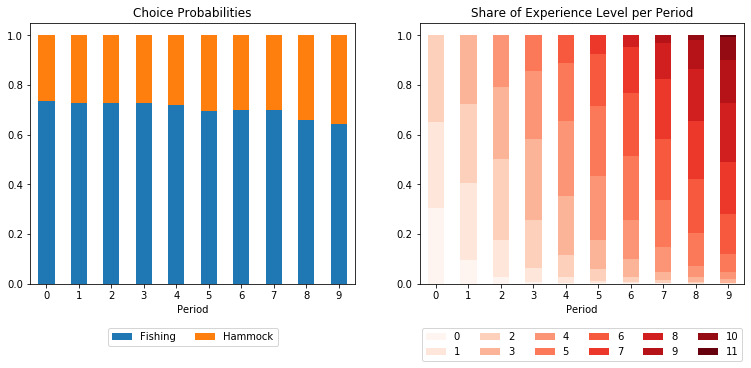

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.8))

(df.groupby("Period").Choice.value_counts(normalize=True).unstack()
 .plot.bar(ax=axs[0], stacked=True, rot=0, title="Choice Probabilities"))
(df.groupby("Period").Experience_Fishing.value_counts(normalize=True).unstack().plot
 .bar(ax=axs[1], stacked=True, rot=0, title="Share of Experience Level per Period", cmap="Reds"))

axs[0].legend(["Fishing", "Hammock"], loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
axs[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=6)

plt.show()
plt.close()

One can clearly see the proportions of experiences in the first period.

## References

Keane, M. P., & Wolpin, K. I. (2000). [Eliminating race differences in school attainment
and labor market success]( <https://www.journals.uchicago.edu/doi/abs/10.1086/209971>`_.
Journal of Labor Economics, 18(4), 614-652.